In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
data_raw = pd.read_excel('DemandPredictionDatasetBR.csv.xlsx',sheet_name = None)
data_raw.head()

,TripId,StartLat,StartLng,EndLat,EndLng,StartDateTime,EndDateTime,Status,CreatedTime
0,359822,18.5867,73.8154,18.5369,73.8713,2014-01-05 18:30:00,2014-01-05 19:30:00,cancelled,2013-12-02 18:33:51
1,365352,18.5809,73.7606,18.5981,73.7187,2014-01-01 10:00:00,2014-01-01 11:00:00,cancelled,2013-12-18 17:56:19
2,365353,18.5826,73.7684,18.5981,73.7187,2014-01-02 10:00:00,2014-01-02 11:00:00,cancelled,2013-12-18 17:56:19
3,365354,18.5826,73.7684,18.5981,73.7187,2014-01-03 10:00:00,2014-01-03 11:00:00,cancelled,2013-12-18 17:56:19
4,365355,18.5826,73.7684,18.5981,73.7187,2014-01-06 10:00:00,2014-01-06 11:00:00,cancelled,2013-12-18 17:58:46


In [3]:
len(data_raw)

181770

In [64]:
df = data_raw[data_raw.StartLat != 0]
df = df[df.EndLat != 0]
df = df[df.StartLat.str.isdigit() != False]
df = df[df.EndLat.str.isdigit() != False]
df = df[df.StartLat < 40]
df = df[df.EndLat < 40]

In [6]:
len(df)

181191

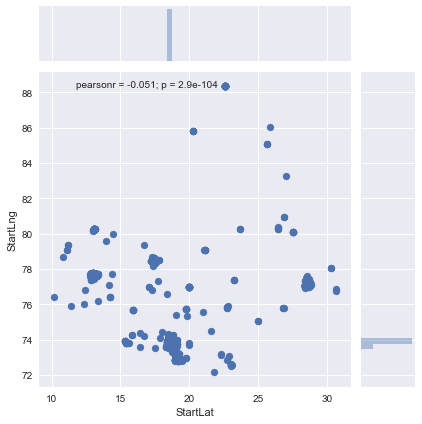

In [7]:
sns.jointplot(x="StartLat", y="StartLng", data=df);

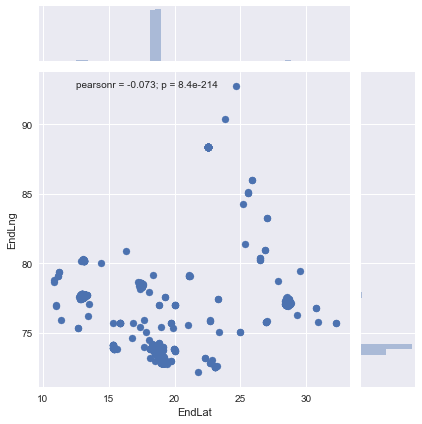

In [8]:
sns.jointplot(x="EndLat", y="EndLng", data=df);

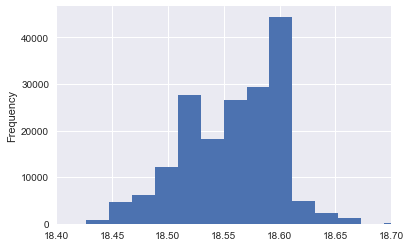

In [58]:
df['StartLat'].plot.hist(xlim=(18.4,18.7),bins=1000) 

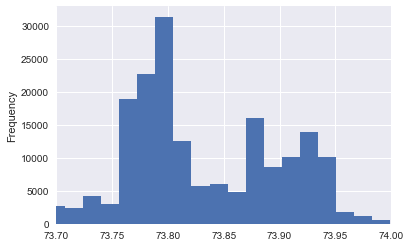

In [69]:
df['StartLng'].plot.hist(xlim=(73.7,74),bins=1000) 

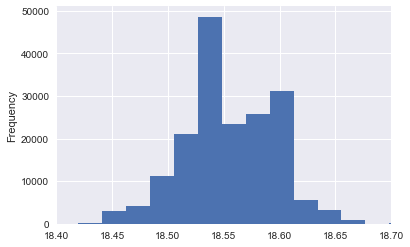

In [59]:
df['EndLat'].plot.hist(xlim=(18.4,18.7),bins=1000) 

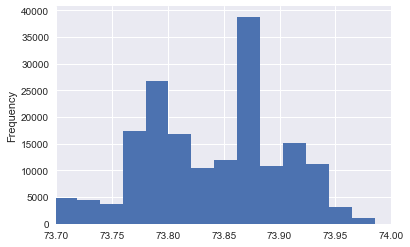

In [60]:
df['EndLng'].plot.hist(xlim=(73.7,74),bins=1000) 

In [65]:
df_train = df

df_train['Distance'] = np.sqrt((df_train['EndLat'] - df_train['StartLat']).astype(float)**2 + (df_train['EndLng'] - df_train['StartLng']).astype(float)**2)


df_train['StartDateTime'] = pd.to_datetime(df_train['StartDateTime'])
df_train['EndDateTime'] = pd.to_datetime(df_train['EndDateTime'])
df_train['CreatedTime'] = pd.to_datetime(df_train['CreatedTime'])
df_train['Month'] = df_train['StartDateTime'].dt.month
df_train['Day'] = df_train['StartDateTime'].dt.day
df_train['Hour'] = df['StartDateTime'].dt.hour + round(df['StartDateTime'].dt.minute / 15) / 4
df_train['Weekend'] = df_train['StartDateTime'].dt.weekday >= 5
df_train['Duration'] = (df_train['EndDateTime']-df_train['StartDateTime']).astype('timedelta64[m]')
df_train['Reservation'] = (df_train['StartDateTime']-df_train['CreatedTime']).astype('timedelta64[D]')

df_train['Outcome'] = df_train['Status'] == 'completed'

df_train = df_train.drop('Status',axis=1)
df_train = df_train.drop('StartDateTime',axis=1)
df_train = df_train.drop('EndDateTime',axis=1)
df_train = df_train.drop('CreatedTime',axis=1)

In [66]:
for col in df_train['StartLat']:
    if col < 18.5:
        df_train['StartLat'] = 1
    elif 18.5 <= col < 18.6:
        df_train['StartLat'] = 2
    else:
        df_train['StartLat'] = 3

In [68]:
for col in df_train['EndLat']:
    if col < 18.5:
        df_train['EndLat'] = 1
    elif 18.5 <= col < 18.6:
        df_train['EndLat'] = 2
    else:
        df_train['EndLat'] = 3

In [70]:
for col in df_train['StartLng']:
    if col < 73.8:
        df_train['StartLng'] = 4
    elif 73.8 <= col < 73.9:
        df_train['StartLng'] = 5
    else:
        df_train['StartLng'] = 6

In [71]:
for col in df_train['EndLng']:
    if col < 73.8:
        df_train['EndLng'] = 4
    elif 73.8 <= col < 73.9:
        df_train['EndLng'] = 5
    else:
        df_train['EndLng'] = 6

In [207]:
df_train.head()

,TripId,StartLat,StartLng,EndLat,EndLng,Distance,Month,Day,Hour,Weekend,Duration,Reservation,Outcome
0,359822,2,4,1,6,0.074870,1,5,18.5,True,60.0,33.0,False
1,365352,2,4,1,6,0.045243,1,1,10.0,False,60.0,13.0,False
2,365353,2,4,1,6,0.052019,1,2,10.0,False,60.0,14.0,False
3,365354,2,4,1,6,0.052019,1,3,10.0,False,60.0,15.0,False
4,365355,2,4,1,6,0.052019,1,6,10.0,False,60.0,18.0,False


Random Forest

In [211]:
X = df_train.reset_index(drop=True)
y = np.where(X['Outcome'] == True, 1,0)
X = X.drop(['TripId','Outcome'],axis=1)
X = X.as_matrix().astype(np.float)

In [212]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [218]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

LR_CV_result = run_cv(X,y,LogisticRegression)
RF_CV_result = run_cv(X,y,RandomForestClassifier)
KNN_CV_result = run_cv(X,y,KNeighborsClassifier)

In [219]:
print("Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result)))
print("Random forest: " + str(accuracy(y, RF_CV_result)))
print("K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result)))

Logistic Regression (L2 is default): 0.767631946399
Random forest: 0.74593660833
K-nearest-neighbors: 0.75015867234


XGBoost

In [203]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

X1 = df_train.reset_index(drop=True)

X_train, X_test = train_test_split(X1,test_size=0.2)

y = np.where(X_train['Outcome'] == True, 1,0)
y_true = np.where(X_test['Outcome'] == True, 1,0)

X2_train = X2_train.drop(['TripId','Outcome'],axis=1)
X2_test = X2_test.drop(['TripId','Outcome'],axis=1)

categorical = ['StartLat','StartLng','EndLat','EndLng']
not_categorical = []
for category in X_train.columns:
    if category not in categorical:
        not_categorical.append(category)


enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(pd.concat([X2_train[categorical],X2_test[categorical]]))

X_cat_sparse=enc.transform(X2_train[categorical])
X_test_cat_sparse=enc.transform(X2_test[categorical])

X_sparse = hstack((X2_train[not_categorical].astype(float), X_cat_sparse))
X_test_sparse = hstack((X2_test[not_categorical].astype(float), X_test_cat_sparse))

del X_cat_sparse
del X_test_cat_sparse

In [200]:
print("Training data: " + format(X_sparse.shape))
print("Labels: " + format(y.shape))

Training data: (144952, 11)
Labels: (144952,)


In [189]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\MinGW\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

In [204]:
dtrain = xgb.DMatrix(X_sparse,label=y)
dtest = xgb.DMatrix(X_test_sparse)

param = {'max_depth':8, 'eta':0.05, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['subsample'] = 0.5
param['colsample_bytree']= 0.5
param['min_child_weight'] = 0
param['booster'] = "gblinear"

In [ ]:
watchlist  = [(dtrain,'train')]
num_round = 1000
early_stopping_rounds=10
bst = xgb.train(param, dtrain, num_round, watchlist,early_stopping_rounds=early_stopping_rounds)

In [206]:
ypred = bst.predict(dtest)
ypred = (ypred >= 0.5).astype(int)
print("XGBoost: " + str(accuracy(y_true, ypred)))

XGBoost: 0.765777201358
